# Reaction Diffusion + Linear Elasticity 

The linear elasticity formulation and be used to inform the reaction diffusion problem. The diffusion constant and source term can be a function of the stresses, with the implication being that high stresses would reduce growth

\begin{align*}
D &= \overline{D}\exp(-\gamma^{Pa}J) \\
\alpha &= \overline{\alpha}\exp(-\gamma^{mob}J)
\end{align*}

The stress itself can be considered a function of the tumor cells. The body forces in the stress formulation could be realted to the gradient of tumor cells, so that where the tumor is growing outwards, there are larger stresses. 

$$\nabla\cdot\sigma = \beta\nabla(\phi) $$

First, the stress problem is solved at each time point. Then, the reaction-diffusion problem is solved using the stress to determine diffusion and growth coefficients.

Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/xoab/miniconda3/lib/python3.6/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/xoab/miniconda3/lib/python3.6/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


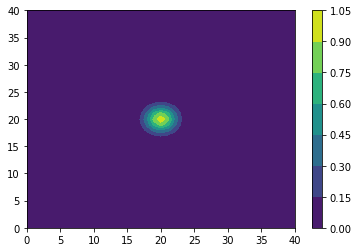

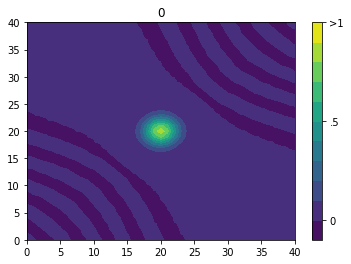

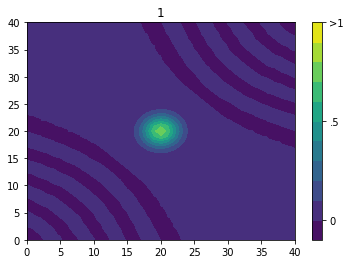

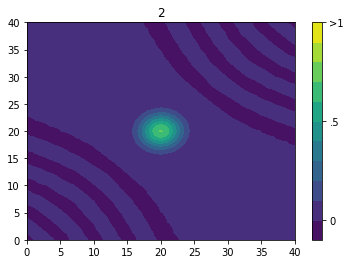

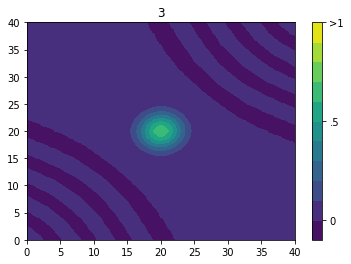

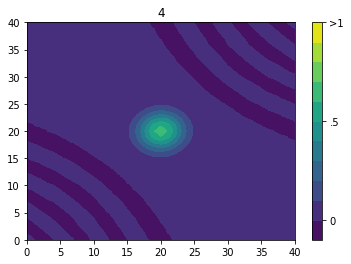

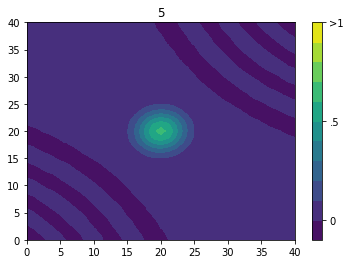

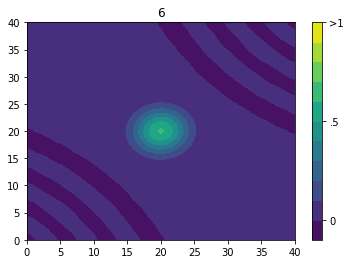

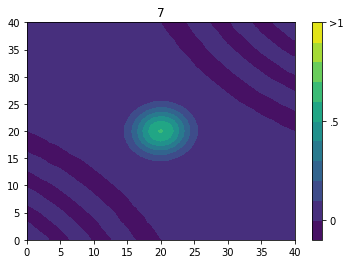

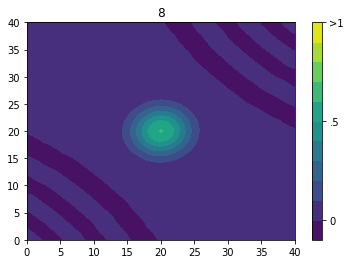

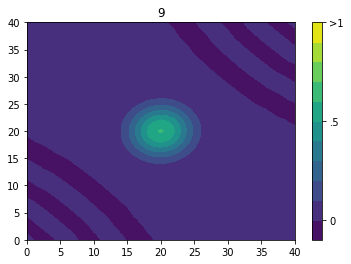

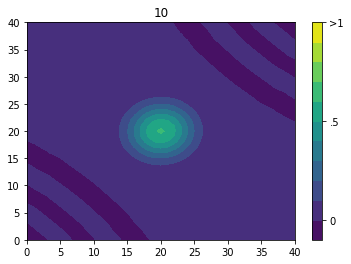

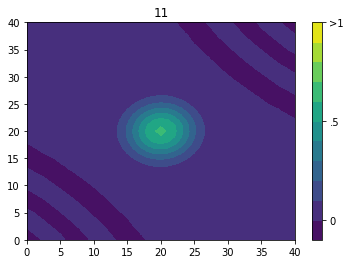

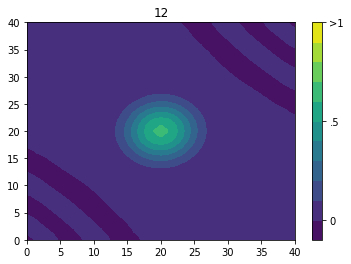

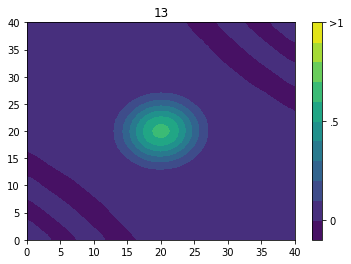

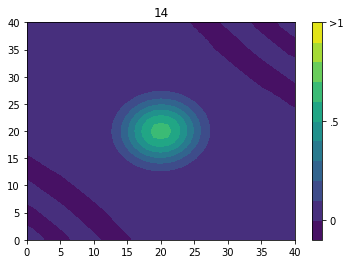

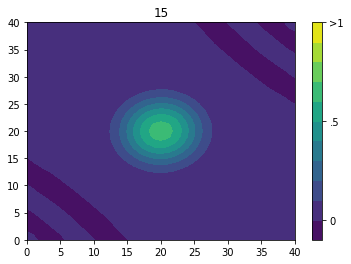

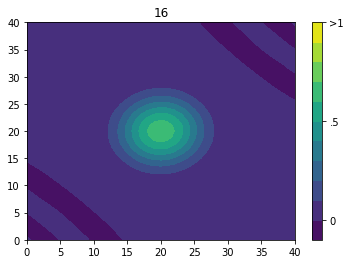

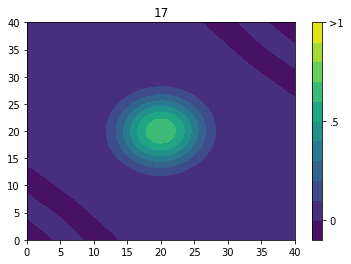

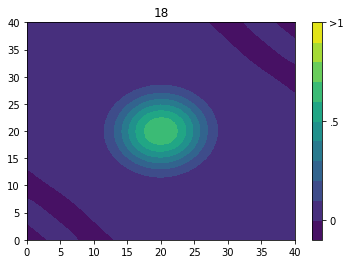

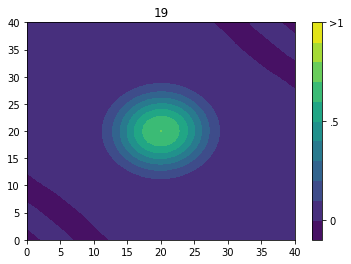

In [14]:
## Reaction Diffusion + Linear Elasticity 

%matplotlib inline
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import time
import os 
import sys
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
import rd
import le

# Variables
T = 1.0            # final time
num_steps = 20     # number of time steps
dt = T / num_steps # time step size
mu = 1.0            # shear modulus
lam = .001
nu = lam/(2*(lam+mu))
EE = lam*(1+nu)*(1-2*nu)/nu
beta = .001
Dt = .05           # Diffusion coefficient
alphat = 2.5       # Reaction coeffecient
gamma1 = 10.       # stress-to-diffusion coefficient
gamma2 = 10       # stress-to-reaction coefficient

# Create mesh and define function spaces
nx = ny = 40
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = VectorFunctionSpace(mesh, 'P', 1) # Function space for displacement
W = FunctionSpace(mesh, 'P',1) # Function space for tumor cells

# Define initial fraction of tumor cells
phi_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))', 
                 degree=2, a=20)
phi_n = interpolate(phi_0,W)
plt.figure()
f = plt.contourf(phi_n.compute_vertex_values().reshape([nx+1,ny+1]))
plt.colorbar(mappable=f)

# Define expressions and functions used in variational forms
D = project(Constant(Dt),W)   # Parameter 1
alpha = project(Constant(alphat),W)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant((0.0,0.0)), boundary)

# Compute solution
os.system('rm ./output/rdle/*')
phifile = XDMFFile('output/rdle/solution.xdmf')
t = 0
for n in range(num_steps):
    t += dt
    
    # Solve variational problem for time step
    vm = le.varprob(V, W, bc, phi_n, mu, lam, beta)
    D = Dt*exp(-gamma1*vm)
    alpha = alphat*exp(-gamma2*vm)
    phi = rd.varprob(dt, W, phi_n, D, alpha)
    
    # Save solution to file (xdmf)
    phifile.write(phi,t)
    phifile.write(vm,t)
    
    # Update previous solution
    phi_n.assign(phi)
    phiarray = phi_n.compute_vertex_values().reshape([nx+1,ny+1])
    
    # Plot
    fig, ax = plt.subplots()
    cax = ax.contourf(phiarray,np.linspace(-.1,1,12))
    ax.set_title(str(n))
    cbar = fig.colorbar(cax,ticks=[0,.5,1],spacing='proportional')
    cbar.set_ticklabels(['0', '.5', '>1'])  # vertically oriented colorbar
    plt.show()
    
del phifile

from xdmf_parser import xparse as xp
xp("output/rdle/solution.xdmf")